In [2]:
import numpy as np
import cv2
import imutils
import os
import math
%matplotlib inline
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow
from google.colab import files

In [3]:
class preProcessing:
    def __init__(self):
      self.img = None
      self.shape = None
      self.len_quad = 150 
      self.kernel = np.ones((3,3),np.uint8)  
      # self.kernel=np.array([[0, 1, 0],
      #                      [1, 1, 1],
      #                      [0, 1, 0]])
      # self.kernel = (5,5)  

    def resize(self, img):
        ratio = len(img[0]) / 1000
        self.img = cv2.resize(img, (0,0), fx=1/ratio, fy=1/ratio)
        
        self.shape = self.img.shape
        # print("resize", self.shape)
        return self.img

    def rgb2gray(self, img):
        r,g,b = img[:,:,0],img[:,:,1],img[:,:,2]
        img = 0.2989 * r + 0.5870 * g + 0.1140 * b
        return img


    def convert_binary(self, img, thresh_val=127):
        white = 255
        black = 0
        
        initial_conv = np.where((img <= thresh_val), img, white)
        final_conv = np.where((initial_conv > thresh_val), initial_conv, black)
        
        return final_conv

    def binarize_this(self, img, thresh_val=127, gray_scale=False):
        
        if not gray_scale:
            cmap_val = None
            r_img, g_img, b_img = img[:, :, 0], img[:, :, 1], img[:, :, 2]
            
            r_b = self.convert_binary(r_img, thresh_val=thresh_val)
            g_b = self.convert_binary(g_img, thresh_val=thresh_val)
            b_b = self.convert_binary(b_img, thresh_val=thresh_val)
            
            image_b = np.dstack(tup=(r_b, g_b, b_b))
        else:
            cmap_val = 'gray'
            image_b = self.convert_binary(img, thresh_val=thresh_val)
      
        return image_b

    def gray(self, img):
        # cv2_imshow(img)
        #gray and filter the image
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        return img

    def bilateralFilter(self, img):
        #bilateral filtering removes noise and preserves edges
        img = cv2.bilateralFilter(img, 11, 17, 17)
        # cv2_imshow(img)
        return img


    def padding(self, img):
        size = self.kernel.shape[1]
        padSize = size//2
        rows = img.shape[0]
        columns = img.shape[1]
        padImg = np.zeros((rows+2*padSize, columns+2*padSize), dtype=np.uint8)
        # Slicing
        padImg[padSize:rows+padSize, padSize:columns+padSize] = img
        return padImg

    def erode(self, img):
        size = self.kernel.shape[1]
        padImg = self.padding(img)
        rows = padImg.shape[0]
        columns = padImg.shape[1]
        output = np.zeros((rows, columns), dtype=np.uint8)
        for i in range(0, rows):
            for j in range(0, columns):
                # Slicing
                portion = padImg[i:i+size, j:j+size]
                # sum of Kernel and window
                portion1 = portion.flatten()
                portion2 = self.kernel.flatten()
                p1 = (np.sum(portion1))
                p2 = (np.sum(portion2))*255
                # if Fit Condition Satisfies
                if p1 == p2:
                    output[i, j] = 255
                else:
                    output[i, j] = np.min(portion1)
        return output

    def dilate(self, img):
        size = self.kernel.shape[1]
        padImg = self.padding(img)
        rows = padImg.shape[0]
        columns = padImg.shape[1]
        output = np.zeros((rows, columns), dtype=np.uint8)
        for i in range(0, rows):
            for j in range(0, columns):
                # Slicing
                portion = padImg[i:i+size, j:j+size]
                portion1 = portion.flatten()
                # if Hit Condition Satisfies
                if 255 in portion1:
                    output[i, j] = 255
                else:
                    output[i, j] = np.max(portion1)
        return output

    def opening(self, img):
        # First apply Erosion
        erosion = self.erode(img)
        # secondly apply Dilation on Eroded
        output = self.dilate(erosion)
        return output

    def closing(self, img):
        # First apply Dilation
        dilation = self.dilate(img)
        # secondly apply Erosion on Dilated
        output = self.erode(dilation)
        return output

    def thresholding(self, f, L):
        # create a new image with zeros
        f_tr = np.ones(f.shape).astype(np.uint8)
        # setting to 0 the pixels below the threshold
        f_tr[np.where(f < L)] = 0
        return f_tr

    def otsu_threshold(self, img, max_L):        
        M = np.product(img.shape)
        min_var = []
        hist_t,_ = np.histogram(img, bins=256, range=(0,256))
        
        img_t = self.thresholding(img, 0)
        
        for L in np.arange(1, max_L):
            img_ti = self.thresholding(img, L)
            # computing weights
            w_a = np.sum(hist_t[:L])/float(M)
            w_b = np.sum(hist_t[L:])/float(M)
            # computing variances
            sig_a = np.var(img[np.where(img_ti == 0)])
            sig_b = np.var(img[np.where(img_ti == 1)])
            
            min_var = min_var + [w_a*sig_a + w_b*sig_b]
            
        img_t = self.thresholding(img, np.argmin(min_var))
        
        return img_t
        
    def otsu(self, img):
        # OTSU
        ret, img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU) 
        # cv2_imshow( img)
        return img

    def quadrants_v4(self, img):
        # crop quadrants of image
        # print("resize", self.shape)
        div = 5
        h, w = self.shape[:2]
        self.len_quad = div
        y, x = int(h/div), int(w/div)
        
        # print('quad',h, w)
        # 1000, 800
        # print(y,x)
        # 200,160
        # roi = img[y1:y2, x1:x2]
        q1 = img[0:y  ,   0:w-x].copy() 
        q2 = img[0:h-y  , (div-1)*x:w].copy()
        q3 = img[(div-1)*y:h,   x:w].copy()
        q4 = img[y:h, 0:x].copy() 
        # Detecting blobs.
        # print('q1') 
        # cv2_imshow(q1)
        return [q1, q2, q3, q4]

    def rotated_rect(self, img, rotation=0):
        if img.shape[0] > img.shape[1] and rotation==1:
            img = imutils.rotate_bound(img, 180)
        elif img.shape[1] > img.shape[0]:
            img = imutils.rotate_bound(img, 90)
        self.shape = img.shape
        self.img = img
        return self.img

    def mount(self, points, n):
        # fix points in image due the tranformation image in quadrants
        # print("points e n ", points, n )
        if len(points)>1:
            point_rect = None
            # print("mount points", points)
            h, w = self.shape[:2]
            div = self.len_quad
            y, x = int(h/div), int(w/div)
            # print(' mount y,x', y,x)
            q = points
            if n==0:
                point_rect = [q[0]     , q[1]     ]
            elif n==1:    
                point_rect = [q[0]+((div-1)*x) , q[1]     ]
            elif n==2:
                point_rect = [q[0]+x     , q[1]+((div-1)*y) ]
            elif n==3:
                point_rect = [q[0], q[1]+y ]
        return point_rect

    def sort_pt_rec(self, keypoints, n):
   
        pt = [ self.mount([k.pt[0], k.pt[1]], n) for k in keypoints ]
        # print("sort_pt", pt)

        # pt = [ [k.pt[0], k.pt[1]] for k in keypoints ]
        # print(pt)
        pt = np.float32(pt)
        c_x = self.shape[1]//2
        c_y = self.shape[0]//2
        dist = np.sqrt((pt[:,0]-c_x)**2 + (pt[:,1]-c_y)**2)
        # print(pt)
        # print(dist)
        indices = np.argsort(dist)[::-1]
        indice = np.argsort(dist)[::-1][0]
        for idx in indices:
           if 16 <= keypoints[indice].size <= 18:
              # print(keypoints[indice].size)
              indice = idx
              break; 
        # print(pt[indice])
        return pt[indice], keypoints[indice].size

    def list_points(self, keypoints):
        # found=[]
        pts=[]
        radius=[]
        for n, keypoint in enumerate(keypoints):
        # find largest blob
            if len(keypoint) > 0:
                # print(keypoints)
                kp_max, point_radius = self.sort_pt_rec(keypoint, n)
                pts.append( kp_max)
                radius.append(point_radius)

        return pts, radius
    

In [4]:
class findBlob:
    def __init__(self):
        self.keypoints = []   
    def BlobDetectorParameter(self, quad):
        
        # Setup SimpleBlobDetector parameters.
        params = cv2.SimpleBlobDetector_Params()

        # # Change thresholds
        # params.minThreshold = 10
        # params.maxThreshold = 200

        # Filter by Area.
        # params.filterByArea = True
        # params.maxArea = 280
        # params.minArea = 200

        # Filter by Circularity
        params.filterByCircularity = True
        params.minCircularity = 0.6

        # Filter by Convexity
        params.filterByConvexity = True
        params.minConvexity = 0.8

        # # Filter by Inertia
        # params.filterByInertia = True
        # params.minInertiaRatio = 0.1


        # Create a detector with the parameters
        detector = cv2.SimpleBlobDetector_create(params)

        # Detect blobs.
        self.keypoints = [detector.detect(q) for q in quad]
        # print(self.keypoints)
        return self.keypoints

    def SimpleBlobDetector(self, quad):  
        # Create a detector without the parameters
        detector = cv2.SimpleBlobDetector_create()

        # Detect blobs.
        self.keypoints = [detector.detect(q) for q in quad]
        # print(self.keypoints)
        return self.keypoints

    def HoughCircles(self, quadrantes):
        circle = None
        kps = []
        for quad in quadrantes:
            keypts = []  
            [circles] = cv2.HoughCircles(quad, cv2.HOUGH_GRADIENT, 1.7, 10, param1=20, param2=10, minRadius=7, maxRadius=18)
            if circles is not None:
                # print("circle")
                # print(circles)
                # print(len(circles))
                for tp in circles:
                    keypts.append(cv2.KeyPoint(tp[0], tp[1], _size=tp[2]))         
                kps.append(keypts)
                # print(keypts)
        self.keypoints = kps
        # print(self.keypoints)
        return self.keypoints

In [5]:
def convert_pts_to_keypoints(pts, sizes): 
    kps = []
    if pts is not None:
        kps = [ cv2.KeyPoint(p[0], p[1], _size=size) for p, size in zip(pts,sizes) ]

    return kps 
def draw_rects(points, sizes, img):
    # draw keypoints
    rect_keypoints = convert_pts_to_keypoints(points, sizes)
    img_rect = cv2.drawKeypoints(img, rect_keypoints, np.array([]), (0,0,255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    cv2_imshow(img_rect)
    # print(points[0] , points[2])
    # draw rectangle
    if ((points[0].any()) and (points[2].any())):
        img_rect1 = cv2.rectangle(img_rect, (int(points[0][0]), int(points[0][1])), (int(points[2][0]), int(points[2][1])), (200,100,0), 2) 
        # cv2_imshow(img_rect)
    elif ((points[1].any()) and (points[3].any())):
        img_rect1 = cv2.rectangle(img_rect, (int(points[1][0]), int(points[1][1])), (int(points[3][0]), int(points[3][1])), (100,200,0), 2)
        # cv2_imshow(img_rect1)
    return img_rect

def draw_lines(points, img):
    # print(points)
    img = cv2.line(img, (int(points[0][0]), int(points[0][1])), (int(points[1][0]), int(points[1][1])), (0,10,255), 4)
    # cv2_imshow(img)
    img = cv2.line(img, (int(points[1][0]), int(points[1][1])), (int(points[2][0]), int(points[2][1])), (0,10,255), 4)
    img = cv2.line(img, (int(points[2][0]), int(points[2][1])), (int(points[3][0]), int(points[3][1])), (0,10,255), 4)
    img = cv2.line(img, (int(points[3][0]), int(points[3][1])), (int(points[0][0]), int(points[0][1])), (0,10,255), 4)
    return img


def distance(points):
    length= []
    for (i, j) in zip(range(4), [1, 2, 3, 0]):
        length.append(math.sqrt( ((points[i][0]-points[j][0])**2)+((points[i][1]-points[j][1])**2) ))
        # print('Length of side {}: {}'.format(i+1, length[i]))
    return length


def code_rect(W, pts, img):
    '''
    Input
      W: referencial line
      pts: coord  initial (0,0)
      img: image 
    returns
      points: coord for exam code rectangle
      n_cod2: image with drawed exam code rectangule
    '''
    points = []
    # Retângulo vermelho superior
    # Canto superior esquerdo →
    points.append([W*0.030469799+pts[0], W*(-0.01791809)+pts[1]])
    # Canto inferior direito → 
    points.append([W*0.62281879+pts[0], W*(0)+pts[1]])

    # Retângulo vermelho inferior:
    # Canto superior esquerdo →
    points.append([W*0.30469799+pts[0], W*0.0053867+pts[1]])
    # Canto inferior direito → 
    points.append([W*0.62281879+pts[0], W*0.02559727+pts[1]])

    img = cv2.rectangle(img, (int(points[0][0]), int(points[0][1])), (int(points[1][0]), int(points[1][1])), (0,0,210), 1)
    img = cv2.rectangle(img, (int(points[2][0]), int(points[2][1])), (int(points[3][0]), int(points[3][1])), (0,0,210), 1)
    # cv2_imshow(n_cod2)

    return points, img

def code_sub_rect (W, pts, img, mode=1):
    points1 = []
    points2 = []
    # print(pts)
    # print(pts[2][1])
    w_px = W*0.0029
    l_px = W*0.015

    dw = 0
    for i in range(24):                          
        points1.append([dw + pts[0][0] + w_px       , pts[0][1] + w_px ])
        points1.append([dw + l_px + pts[0][0]       , l_px + pts[0][1] ])
        dw += l_px + w_px

        if i%2==0:
            img = cv2.rectangle(img, (int(points1[i][0]), int(points1[i][1])), (int(points1[i+1][0]), int(points1[i+1][1])), (200,50,0), 1)
    dw = 0
    for i in range(24):                            
        points2.append([dw + pts[2][0] + w_px       , pts[2][1] + w_px ])
        points2.append([dw + l_px + pts[2][0]       , l_px + pts[2][1] ])
        dw += l_px + w_px

        if i%2==0:
            img = cv2.rectangle(img, (int(points2[i][0]), int(points2[i][1])), (int(points2[i+1][0]), int(points2[i+1][1])), (50,200,0), 1)

    return points1, points2, img

def recognize_code(pts, image):
    c=0
    myPixelVal = np.zeros(12) 
    for i in range(24):
        if i%2==0:
          idx = int(i/2)
          img_qd = image[int(pts[i][1]):int(pts[i+1][1]), int(pts[i][0]):int(pts[i+1][0])]
          # totalPixels = cv2.countNonZero(img_qd)
          # n_white_pix = np.sum(img_qd == 255)
          # print('white', n_white_pix )
          # print(totalPixels)
          if np.sum(img_qd == 255)<np.sum(img_qd == 0):
              myPixelVal[idx]= 1
    # print("myPixelVal reversed\n", myPixelVal[::-1])
    # print("myPixelVal\n", myPixelVal)
    return myPixelVal

def covert_binary_to_decimal(code):
    result = 0
    for i, n in enumerate(reversed(code)):
        # print(i,n)
        result += int(n)*(2**i)
    return result

def val_code(test, page):
    code=60-((test-1)*4+(page-1))%60
    return code


def order_points(pts):
    # initialzie a list of coordinates that will be ordered
    # such that the first entry in the list is the top-left,
    # the second entry is the top-right, the third is the
    # bottom-right, and the fourth is the bottom-left
    rect = np.zeros((4, 2), dtype = "float32")
    # the top-left point will have the smallest sum, whereas
    # the bottom-right point will have the largest sum
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    # now, compute the difference between the points, the
    # top-right point will have the smallest difference,
    # whereas the bottom-left will have the largest difference
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    # return the ordered coordinates
    return rect

def four_point_transform(image, pts):
    # obtain a consistent order of the points and unpack them
    # individually
    shape= []
    rect = order_points(pts)
    (tl, tr, br, bl) = rect
    # print(tl)
    # compute the width of the new image, which will be the
    # maximum distance between bottom-right and bottom-left
    # x-coordiates or the top-right and top-left x-coordinates
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))
    # compute the height of the new image, which will be the
    # maximum distance between the top-right and bottom-right
    # y-coordinates or the top-left and bottom-left y-coordinates
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
    # now that we have the dimensions of the new image, construct
    # the set of destination points to obtain a "birds eye view",
    # (i.e. top-down view) of the image, again specifying points
    # in the top-left, top-right, bottom-right, and bottom-left
    # order
    dst = np.array([
      [0, maxHeight*0.04],
      [maxWidth , maxHeight*0.04],
      [maxWidth , maxHeight ],
      [0, maxHeight ]], dtype = "float32")
    # compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(rect, dst)
    # print(M)
    shape=[ maxHeight,maxWidth ]
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    # return the warped image
    # print('four_point_transform', shape)
    # New points cause four_point_transform function
    points = [[0,shape[0]*0.04],[shape[1],shape[0]*0.04], [shape[1],shape[0]], [0,shape[0]]]
    
    return warped, points

In [6]:
def code_rect(W, pts, img):
    '''
    Input
      W: referencial line
      pts: coord  initial (0,0)
      img: image 
    returns
      points: coord for exam code rectangle
      n_cod2: image with drawed exam code rectangule
    '''
    points = []
  
    # Retângulo vermelho superior
    # Canto superior esquerdo →
    points.append([W*0.210+pts[0], W*(-0.0434)+pts[1]])
    # Canto inferior direito → 
    points.append([W*0.473+pts[0], W*(-0.025)+pts[1]])

    # Retângulo vermelho inferior:
    # Canto superior esquerdo →
    points.append([W*0.210+pts[0], W*(-0.02075)+pts[1]])
    # Canto inferior direito → 
    points.append([W*0.473+pts[0], W*(-0.0031)+pts[1]])

    print(W)
    print(points)
    img = cv2.rectangle(img, (int(points[0][0]), int(points[0][1])), (int(points[1][0]), int(points[1][1])), (0,0,210), 1)
    img = cv2.rectangle(img, (int(points[2][0]), int(points[2][1])), (int(points[3][0]), int(points[3][1])), (0,0,210), 1)
    cv2_imshow(img)

    return points, img

def code_sub_rect (W, pts, img, mode=1):
    points1 = []
    points2 = []
    # print(pts)
    # print(pts[2][1])
    #w_px = W*0.0050
    #l_px = W*0.017
    w_px = W*0.0080
    l_px = W*0.014

    dw = 0
    for i in range(24):                          
        points1.append([dw + pts[0][0] + w_px       , pts[0][1] + w_px ])
        points1.append([dw + l_px + pts[0][0]       , l_px + pts[0][1] ])
        dw += l_px + w_px

        if i%2==0:
            img = cv2.rectangle(img, (int(points1[i][0]), int(points1[i][1])), (int(points1[i+1][0]), int(points1[i+1][1])), (200,50,0), 1)
    dw = 0
    for i in range(24):                            
        points2.append([dw + pts[2][0] + w_px       , pts[2][1] + w_px ])
        points2.append([dw + l_px + pts[2][0]       , l_px + pts[2][1] ])
        dw += l_px + w_px

        if i%2==0:
            img = cv2.rectangle(img, (int(points2[i][0]), int(points2[i][1])), (int(points2[i+1][0]), int(points2[i+1][1])), (50,200,0), 1)

    return points1, points2, img

In [10]:
import random

In [84]:
def usp_rect(W, pts, img):
    '''
    Input
      W: referencial line
      pts: coord  initial (0,0)
      img: image 
    returns
      points: coord for exam code rectangle
      n_cod2: image with drawed exam code rectangule
    '''
    points = []

    #for i in range(10):
    #  if i == 0:
        # primeiro retangulo
        # Canto superior esquerdo →
        #points.append([W*0.14362416+pts[0], W*0.05771812+pts[1]])
    points.append([W*0.00000112+pts[1],W*0.14362416+pts[0]])
        # Canto inferior direito → 
    points.append([W*0.02615789+pts[1],W*0.47651007+pts[0]])
      #else:
        # primeiro retangulo
        # Canto superior esquerdo →
      #  points.append([W*0.14362416+pts[0], W*0.05771812+pts[1]])
        # Canto inferior direito → 
      #  points.append([W*0.47651007+pts[0], points[i-1][1]+25+pts[1]])
      
    img = cv2.rectangle(img, (int(points[0][0]), int(points[0][1])), (int(points[1][0]), int(points[1][1])), (0,0,210), 1)
    add = int(points[1][0]) - int(points[0][0])+1
    new_x0 = int(points[0][0])+add
    new_xn = int(points[1][0])+add
    points.append([new_x0,points[0][1]])
    points.append([new_xn,points[1][1]])
    img = cv2.rectangle(img, (new_x0, int(points[0][1])), (new_xn, int(points[1][1])), (random.randint(0,255),random.randint(0,255),random.randint(0,255)), 1)
    #new_x0 = new_x0+add
    #new_xn = new_xn+add
    #points.append([new_x0,points[0][1]])
    #points.append([new_xn,points[1][1]])
    #img = cv2.rectangle(img, (new_x0, int(points[0][1])), (new_xn, int(points[1][1])), (random.randint(0,255),random.randint(0,255),random.randint(0,255)), 1)
    
    plt.imshow(img)

    return points, img

def usp_sub_rect (W, pts, img, mode=1):
    points1 = []
    points2 = []
    # print(pts)
    # print(pts[2][1])
    #w_px = W*0.0050
    #l_px = W*0.017
    w_px = W*0.0080
    l_px = W*0.016

    dw = 2
    for i in range(20):                          
        points1.append([pts[0][0] + w_px,  dw + pts[0][1] + w_px ])
        points1.append([l_px + pts[0][0],dw + l_px + pts[0][1]])
        dw += l_px + w_px + 7

        if i%2==0:
          img = cv2.rectangle(img, (int(points1[i][0]), int(points1[i][1])), (int(points1[i+1][0]), int(points1[i+1][1])), (200,50,0), 1)
    dw = 0
    '''
    for i in range(10):                            
        points2.append([dw + pts[2][1] + w_px       , pts[2][0] + w_px ])
        points2.append([dw + l_px + pts[2][1]       , l_px + pts[2][0] ])
        dw += l_px + w_px

        if i%2==0:
            img = cv2.rectangle(img, (int(points2[i][1]), int(points2[i][0])), (int(points2[i+1][1]), int(points2[i+1][0])), (50,200,0), 1)
    '''
    return points1, img

In [46]:
def detect_code(full_path, method=2):
    print("\nPath image: ", full_path)
    image = cv2.imread(full_path)
    # cv2_imshow(image)
    # print("shape", image.shape)
    image_original = pre.resize(image)
    # Operacoes morfologicas

    image_original = pre.rgb2gray(np.array(image_original)).copy()

    image = pre.binarize_this(image_original, 127, True)
    # print('binarization')
    # cv2_imshow(image)

    image = pre.closing(image)
    # print('closing')
    # cv2_imshow(image)


    image = pre.dilate(image)
    # print('dilate')
    # cv2_imshow(image)


    image_opening = pre.opening(image)
    # print('opening')
    # cv2_imshow(image)

    test_blob, page_blob, n_code_blob = None, None, None
    dist, points, img_rect = None, None, None

    for n in range(0,1):
        # img = image.copy()
        image = pre.rotated_rect(image, n)
        # print("shape rotated_rect", n)
        img = image.copy()
        

        # Transform image in 4 quadrants
        quad = pre.quadrants_v4(img)
        if method == 1:
            # Call Detection blob function in 4 quadrants
            keypoints = blob.SimpleBlobDetector(quad)
            # print('Method SimpleBlobDetector')
        elif method == 2:
            keypoints = blob.BlobDetectorParameter(quad)
            # print('Method BlobDetectorParameter')
        elif method == 3:
            keypoints = blob.HoughCircles(quad)
            # print('Method HoughCircles')

        # Return 4 coordinates of points 
        points, sizes = pre.list_points(keypoints)
        # print("sizes",sizes)
        # im_with_keypoints = cv2.drawKeypoints(quad[0], points[0], np.array([]), (20,200,0), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

        # Draw rects and lines
        img_rect = draw_rects(points, sizes, img)
        img_rect = draw_lines(points, img)


        # Correcting image rotation and perspective
        image_original = pre.rotated_rect(image_original, n)
        # image_original = pre.otsu(image_original)
        # image_original, _ = pre.otsu_threshold(image_original, 255)
        image_original = pre.binarize_this(image_original, 127, True)
        img_rect, points = four_point_transform(image_original, np.array(points, dtype = "float32"))
        # cv2_imshow(img_rect)

        # img_rect = draw_lines(points, img_rect)
        dist = distance(points)


        # Finding the EXAM INFORMATION rectangle
        pt_code, img_rect = code_rect(dist[0], points[0], img_rect)


        # Dividing the EXAM INFORMATION rectangle into subrectangles and returning yours coordinates
        pt_sub_code1, pt_sub_code2, img_rect = code_sub_rect(dist[0], pt_code, img_rect)

        # Recognize blobs in subrects code and return binary number
        code1 = recognize_code(pt_sub_code1, img_rect)
        code2 = recognize_code(pt_sub_code2, img_rect)

        # Convert binary to decimal    
        test_blob = covert_binary_to_decimal(code1)
        page_blob = covert_binary_to_decimal(code2[:6])
        n_code_blob = covert_binary_to_decimal(code2[6:])

        if test_blob > 0 and page_blob>0:
            if isinstance(n_code_blob, int):
                # print("Exam information read:\nteste number: {}\npage: {} code: {}".format(test_blob, page_blob, n_code_blob))
                # Code math validation
                v_code = val_code(test_blob, page_blob)
                if v_code == n_code_blob:
                    print("Calculated code: {} {} equals code read: {}".format(v_code, "is", n_code_blob))          
                else:
                    print("Calculated code: {} {} equals Code read: {}".format(v_code, "is not", n_code_blob)) 
                    print("Unsuccessful detection")
                    break;

        elif (test_blob == 0 or page_blob==0) and n==1:
            print("Page number or exam number not recognized")
            print("Unsuccessful detection")
            break;
    pt_code_usp, img_rect = usp_rect(dist[0], points[0], img_rect)
    pt_usp_code1, img_rect = usp_sub_rect(dist[0], pt_code_usp, img_rect)

    cv2_imshow(img_rect)
    
    return [test_blob, page_blob, n_code_blob] 

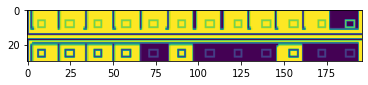

In [58]:
plt.imshow(img_rect[16:46,156:352])

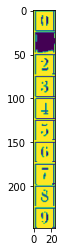

In [73]:
plt.imshow(img_rect[107:355,43:68])

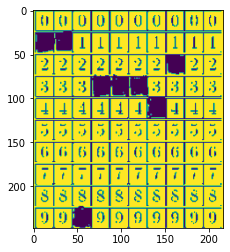

In [67]:
plt.imshow(img_rect[107:355,43:260])


Path image:  Prova_standard.jpg


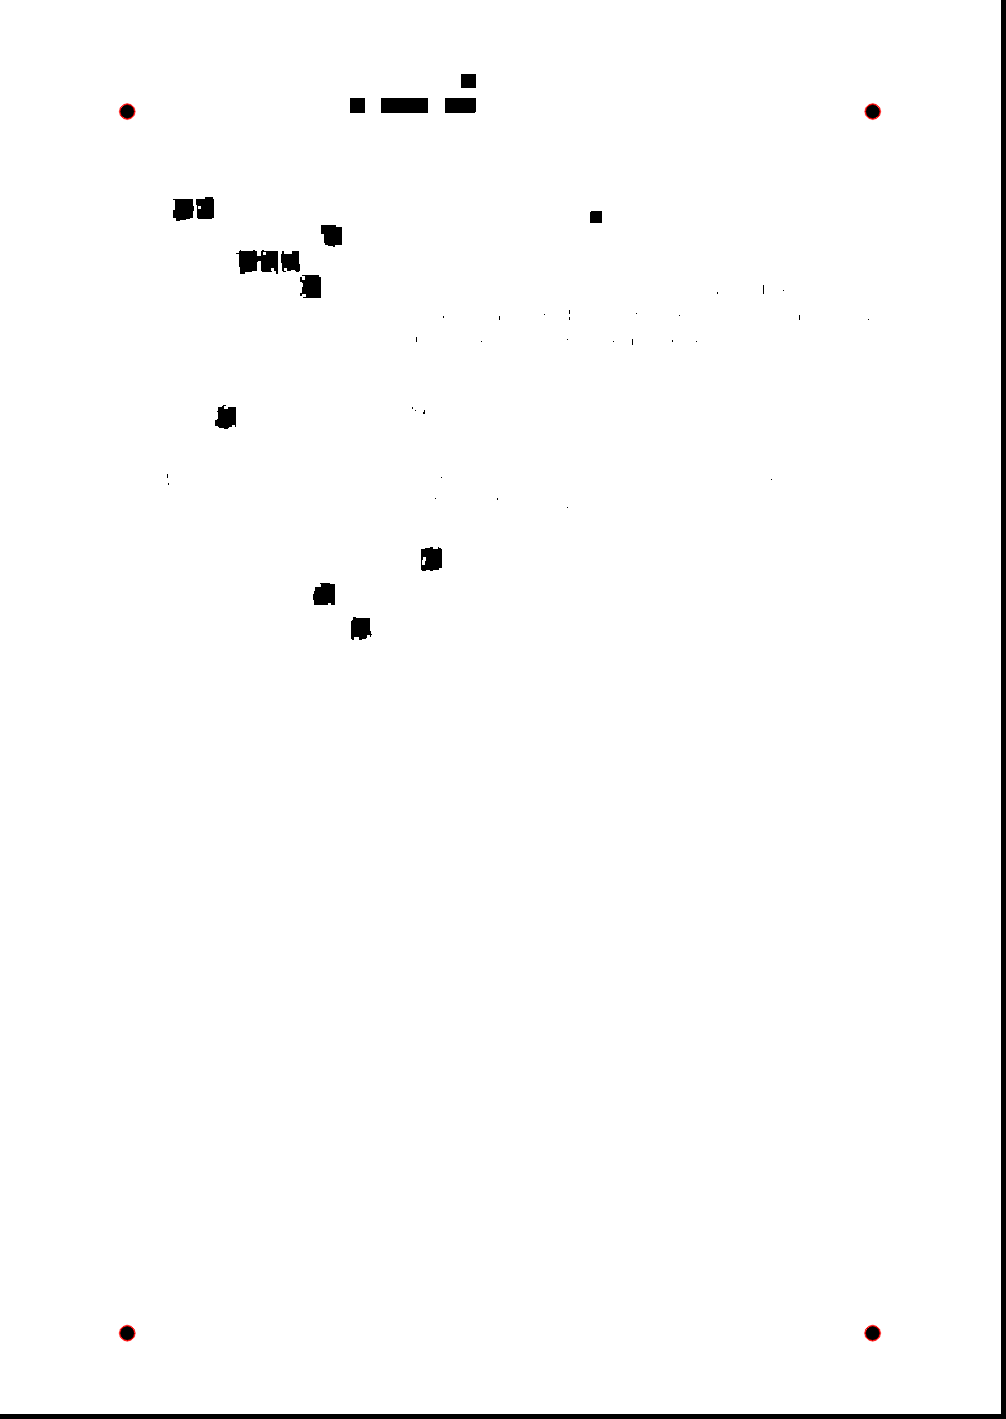

745.0
[[156.45, 16.507000000000005], [352.385, 30.215000000000003], [156.45, 33.38125], [352.385, 46.5305]]


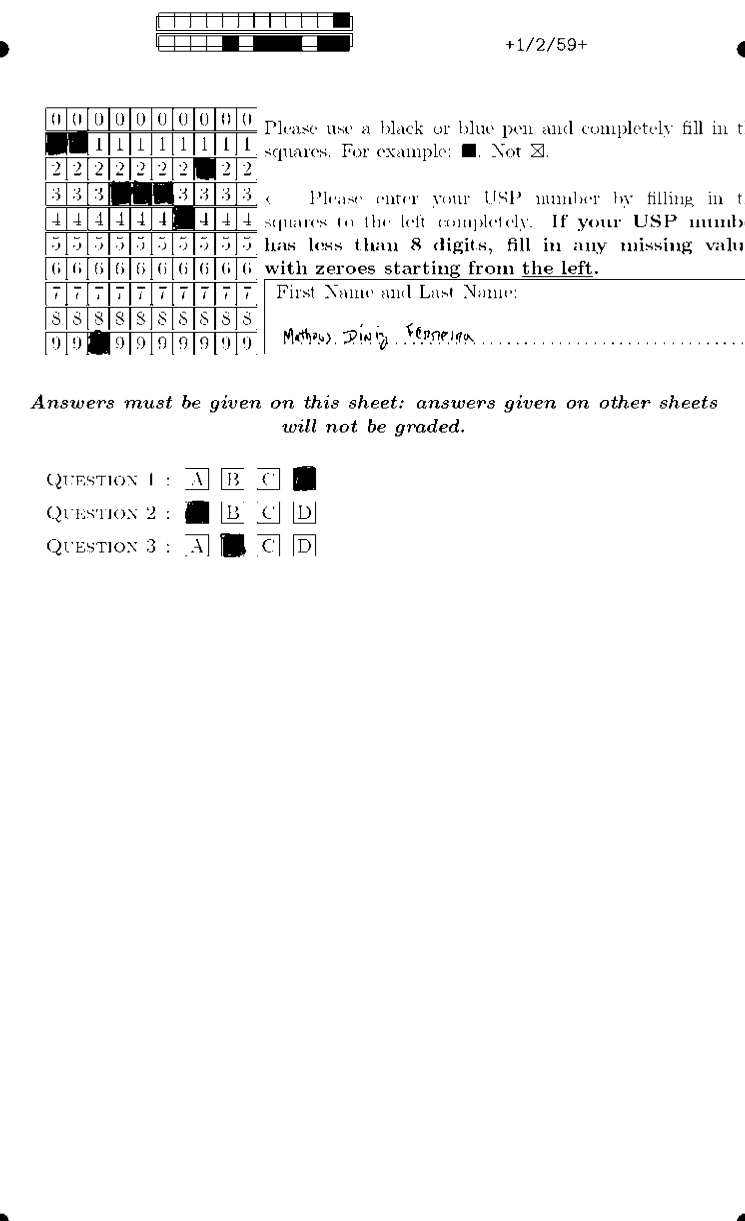

Calculated code: 59 is equals code read: 59


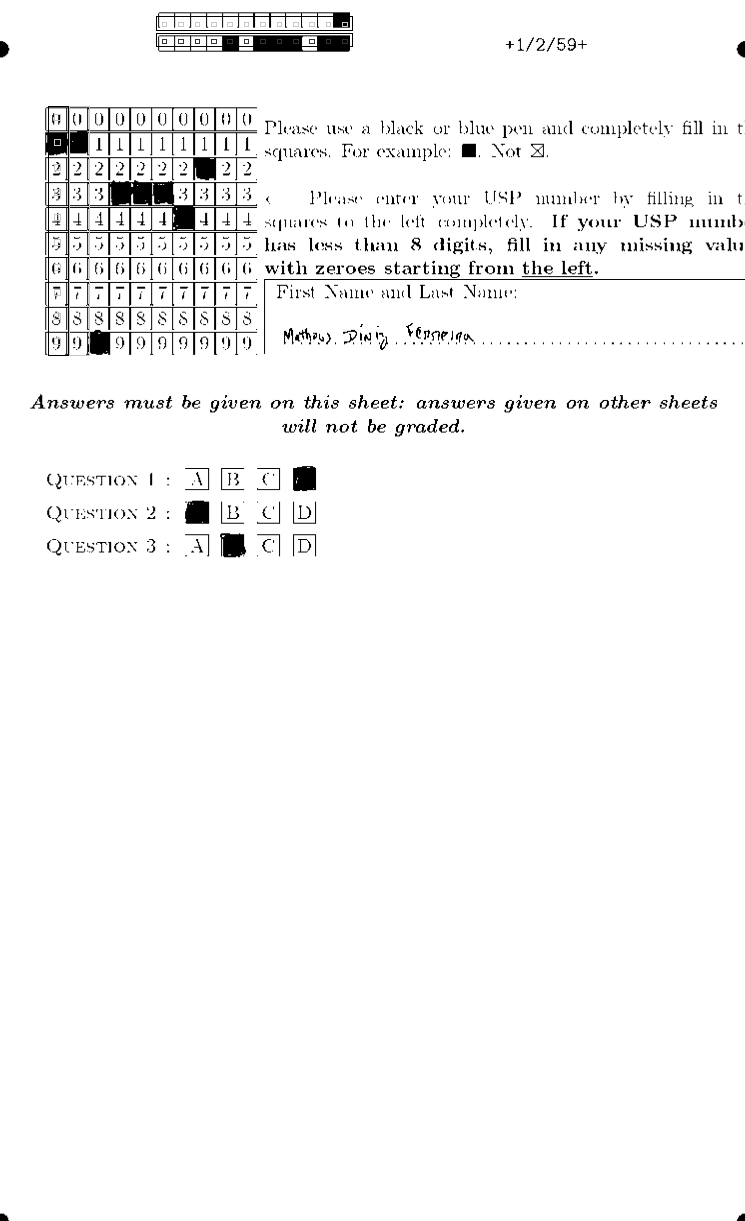

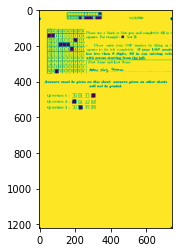

In [85]:
pre = preProcessing()
blob = findBlob()
result = []
result = detect_code('Prova_standard.jpg', method=2)


Path image: 


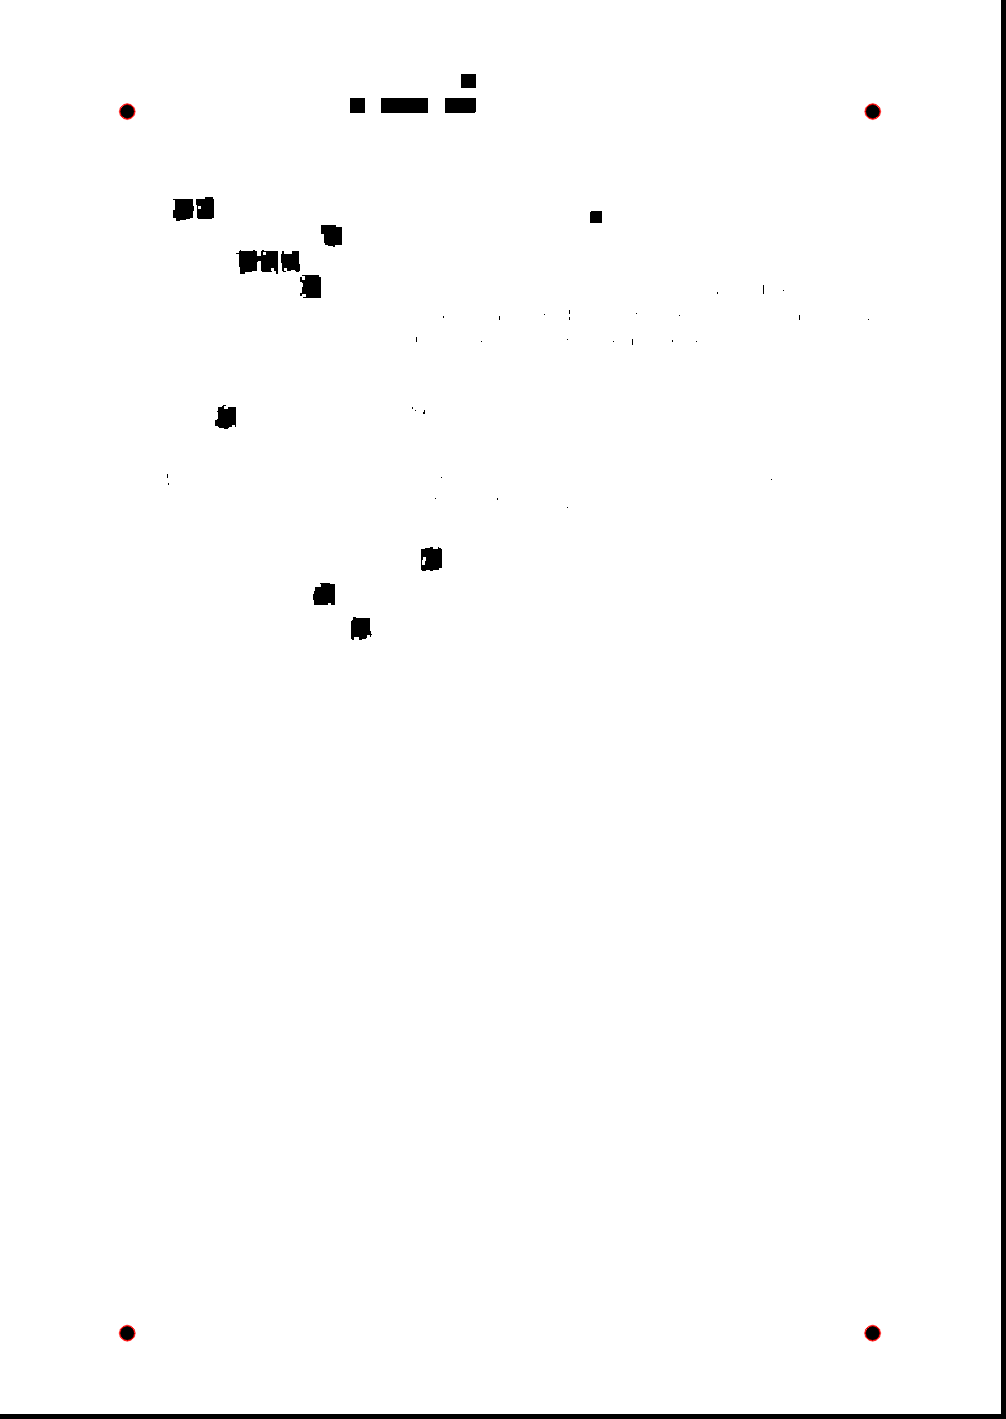

745.0
[[156.45, 16.507000000000005], [352.385, 30.215000000000003], [156.45, 33.38125], [352.385, 46.5305]]


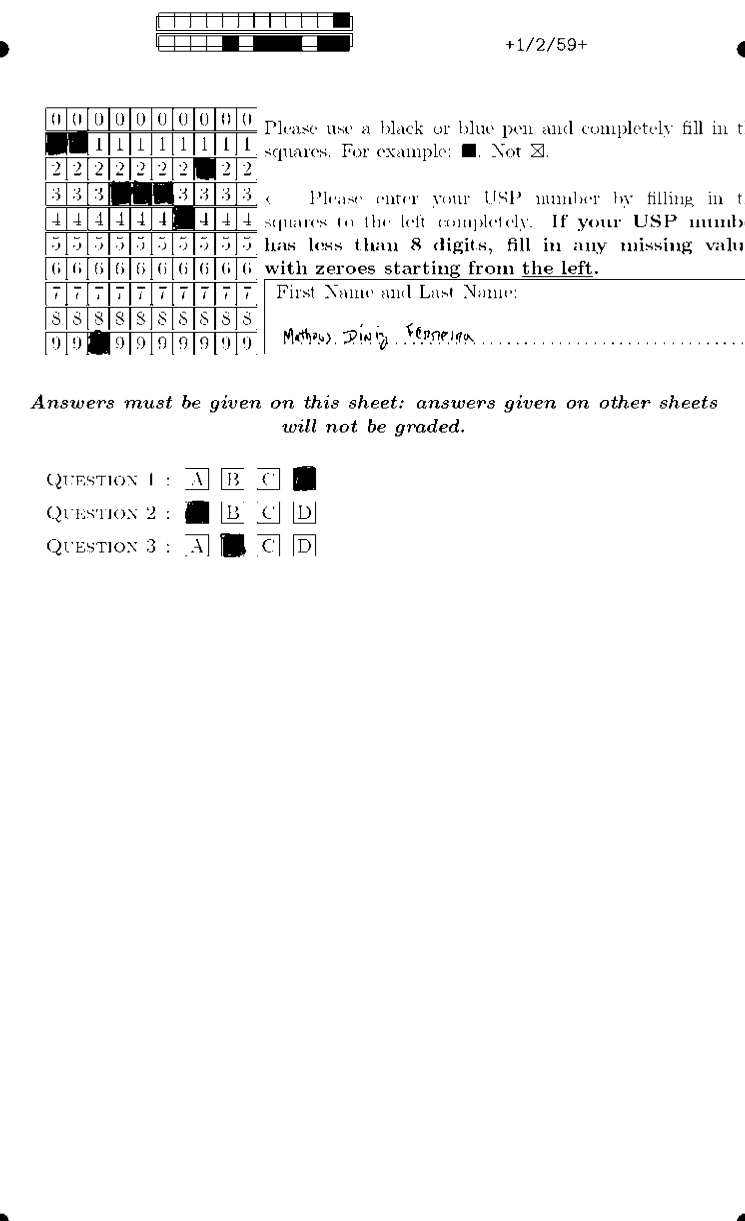

In [23]:
  print("\nPath image: ", )
  image = cv2.imread('Prova_standard.jpg')
  # cv2_imshow(image)
  # print("shape", image.shape)
  image_original = pre.resize(image)
  # Operacoes morfologicas

  image_original = pre.rgb2gray(np.array(image_original)).copy()

  image = pre.binarize_this(image_original, 127, True)
  # print('binarization')
  # cv2_imshow(image)

  image = pre.closing(image)
  # print('closing')
  # cv2_imshow(image)


  image = pre.dilate(image)
  # print('dilate')
  # cv2_imshow(image)


  image_opening = pre.opening(image)
  # print('opening')
  # cv2_imshow(image)

  test_blob, page_blob, n_code_blob = None, None, None
  dist, points, img_rect = None, None, None

  for n in range(0,1):
      # img = image.copy()
      image = pre.rotated_rect(image, n)
      # print("shape rotated_rect", n)
      img = image.copy()
      

      # Transform image in 4 quadrants
      quad = pre.quadrants_v4(img)
      keypoints = blob.BlobDetectorParameter(quad)
          

      # Return 4 coordinates of points 
      points, sizes = pre.list_points(keypoints)
      # print("sizes",sizes)
      # im_with_keypoints = cv2.drawKeypoints(quad[0], points[0], np.array([]), (20,200,0), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

      # Draw rects and lines
      img_rect = draw_rects(points, sizes, img)
      img_rect = draw_lines(points, img)


      # Correcting image rotation and perspective
      image_original = pre.rotated_rect(image_original, n)
      # image_original = pre.otsu(image_original)
      # image_original, _ = pre.otsu_threshold(image_original, 255)
      image_original = pre.binarize_this(image_original, 127, True)
      img_rect, points = four_point_transform(image_original, np.array(points, dtype = "float32"))
      # cv2_imshow(img_rect)

      # img_rect = draw_lines(points, img_rect)
      dist = distance(points)


      # Finding the EXAM INFORMATION rectangle
      pt_code, img_rect = code_rect(dist[0], points[0], img_rect)

      # Dividing the EXAM INFORMATION rectangle into subrectangles and returning yours coordinates
      pt_sub_code1, pt_sub_code2, img_rect = code_sub_rect(dist[0], pt_code, img_rect)

      # Recognize blobs in subrects code and return binary number
      code1 = recognize_code(pt_sub_code1, img_rect)
      code2 = recognize_code(pt_sub_code2, img_rect)

      # Convert binary to decimal    
      test_blob = covert_binary_to_decimal(code1)
      page_blob = covert_binary_to_decimal(code2[:6])
      n_code_blob = covert_binary_to_decimal(code2[6:])